In [1]:
import json
import os
import numpy as np


def read_raw(rec_path, timestamp, data_type):
    data = None
    with open(os.path.join(rec_path, f'{data_type}_{timestamp}.txt')) as f:
        data = json.load(f)
    return data

def extract_quat_array(data, offset=None):
    data = [[val['x'], val['y'], val['z'], val['w']] for val in data]
    data = np.array(data)
    if offset is not None:
        return data[offset:]
    return data


def extract_vec3_array(data, offset=None, is_homogeneous=False):
    if is_homogeneous:
        data = [[val['x'], val['y'], val['z'], 1.0] for val in data]
    else:
        data = [[val['x'], val['y'], val['z']] for val in data]
    data = np.array(data)
    if offset is not None:
        return data[offset:]
    return data




def get_processed_hl_data(rec_path, plot=False, interp=False):
    rec_name = rec_path.split('\\')[-1]
    folder_timestamp = list(filter(lambda x: 'WatchSensors_' in x, os.listdir(rec_path)))[0].split('_')[1].split('.')[0]
    watch = read_raw(rec_path, folder_timestamp, "WatchSensors")

    #### Extract Key Information
    GLOBAL_REC_OFFSET = 1

    watch = watch[GLOBAL_REC_OFFSET:]
    watch_acc = [val for frame in watch for val in frame['acc']]
    watch_acc = extract_vec3_array(watch_acc, is_homogeneous=False)[1:]
    watch_gyr = [val for frame in watch for val in frame['gyro']]
    watch_gyr = extract_vec3_array(watch_gyr)[1:]

    watch_acc_ts = np.array([ts for frame in watch for ts in frame['accTS']])
    watch_acc_ts = [int((ts - watch_acc_ts[0])/1000000) for ts in watch_acc_ts[1:]]
    watch_acc_dts = np.array([(watch_acc_ts[i+1] - watch_acc_ts[i]) / 1000.0 for i in range(len(watch_acc_ts) - 1)])
    # watch_acc_ts = np.array([ts - watch_acc_ts[0] for ts in watch_acc_ts[1:]])
    watch_acc_ts = np.array(watch_acc_ts)

    watch_gyr_ts = np.array([ts for frame in watch for ts in frame['gyroTS']])
    watch_gyr_ts = [int((ts - watch_gyr_ts[0])/1000000) for ts in watch_gyr_ts[1:]]
    watch_gyr_dts = np.array([(watch_gyr_ts[i+1] - watch_gyr_ts[i]) / 1000.0 for i in range(len(watch_gyr_ts) - 1)])
    # watch_gyr_ts = np.array([ts - watch_gyr_ts[1] for ts in watch_gyr_ts[1:]])
    watch_gyr_ts = np.array(watch_gyr_ts)

    print(f"Watch Duration: {watch_acc_ts[-1]}")

    return watch_acc,watch_acc_ts,watch_gyr,watch_gyr_ts

def get_processed_activity_data(rec_path, plot=False, interp=False):
    folder_timestamp = list(filter(lambda x: 'ActivityLabels_' in x, os.listdir(rec_path)))[0].split('_')[1].split('.')[0]
    watch = read_raw(rec_path, folder_timestamp, "ActivityLabels")

    #### Extract Key Information
    watch_activity = [frame['activityName'] for frame in watch]
    activity_ts = [frame['_recTS'] for frame in watch]

    return watch_activity, activity_ts



In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

#functions for training and validation
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if batch_index % 100 == 99:  # print every 100 batches
        #     avg_loss_across_batches = running_loss / 100
        #     print('Batch {0}, Loss: {1:.3f}'.format(batch_index + 1,
        #                                             avg_loss_across_batches))
        #     running_loss = 0.0


    avg_loss_across_batches = running_loss / len(test_loader)
    print('Train Loss: {0:.3f}'.format(avg_loss_across_batches))
    print()
    return avg_loss_across_batches


def validate_one_epoch():
    model.train(False)
    running_loss_val = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch_test, y_batch_test = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output_test = model(x_batch_test)
            loss_test = loss_function(output_test, y_batch_test)
            running_loss_val += loss_test.item()

    avg_loss_across_batches_val = running_loss_val / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches_val))
    print('***************************************************')
    print()
    return avg_loss_across_batches_val

In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# get paths to recordings
rec_path = "drive/MyDrive/watch_activity_model/recordings_with_tools"
#rec_path = "drive/MyDrive/watch_activity_model/valid_new_whisk"
#rec_path = "drive/MyDrive/watch_activity_model/Test_Data"
recs = [os.path.join(rec_path, filename) for filename in os.listdir(rec_path)]


In [4]:
!ls drive/MyDrive/watch_activity_model/Recs/rec_12
print(device)


ActivityLabels_1043.txt  WatchSensors_1043.txt
cuda:0


In [5]:
x_data = []
y_data = []
labels = np.eye(4)

#lentgh of the sequence can be set here (time window = seq_lentgh / 40Hz)
seq_length = 40

for rec in recs:
    print(rec)
    watch_acc, watch_acc_ts, watch_gyr, watch_gyr_ts = get_processed_hl_data(rec)
    watch_data = np.hstack((watch_acc, watch_gyr))
    activity, TS = get_processed_activity_data(rec)

    size_rec = len(watch_data)//seq_length
    modulo = len(watch_data) % seq_length
    if modulo < int(seq_length/2):
        size_rec -= 1

    x = np.zeros((2*size_rec, seq_length, 6))
    y = np.zeros((2*size_rec,4))
    #helper variables
    counter = 0
    k = 0

    for i in range(size_rec):
        index1 = seq_length*i
        index2 = index1 + int(seq_length/2)

        y[2*i] = labels[k]
        y[(2*i)+1] = labels[k]

        if TS[counter] < index1+50:
            if counter % 2 == 0:
                if activity[counter] == 'cut':
                    k = 1
                if activity[counter] == 'whisk':
                    k = 2
                if activity[counter] == 'put_into':
                    k = 3
            else:
                k = 0
            y[2*i] = labels[k]
            y[(2*i)+1] = labels[k]
            counter += 1

        elif TS[counter] < index2+50:
            if counter % 2 == 0:
                if activity[counter] == 'cut':
                    k = 1
                if activity[counter] == 'whisk':
                    k = 2
                if activity[counter] == 'put_into':
                    k = 3
            else:
                k = 0
            y[(2*i)+1] = labels[k]
            counter += 1

        x[2*i] = watch_data[index1:index1+seq_length]
        x[(2*i)+1] = watch_data[index2:(index2 + seq_length)]

        if counter == len(TS):
            counter = 0
            TS[0] = 1000000000

    x_data.append(x)
    y_data.append(y)

x_data = np.concatenate(x_data, axis=0)
y_data = np.concatenate(y_data, axis=0)


drive/MyDrive/watch_activity_model/recordings_with_tools/rec_15
Watch Duration: 25838
drive/MyDrive/watch_activity_model/recordings_with_tools/rec_7
Watch Duration: 24150
drive/MyDrive/watch_activity_model/recordings_with_tools/rec_3
Watch Duration: 12885
drive/MyDrive/watch_activity_model/recordings_with_tools/rec_12
Watch Duration: 25992
drive/MyDrive/watch_activity_model/recordings_with_tools/rec_19
Watch Duration: 26950
drive/MyDrive/watch_activity_model/recordings_with_tools/rec_1
Watch Duration: 22456
drive/MyDrive/watch_activity_model/recordings_with_tools/rec_33
Watch Duration: 131277
drive/MyDrive/watch_activity_model/recordings_with_tools/rec_6
Watch Duration: 20464
drive/MyDrive/watch_activity_model/recordings_with_tools/rec_34
Watch Duration: 61099
drive/MyDrive/watch_activity_model/recordings_with_tools/rec_25
Watch Duration: 25879
drive/MyDrive/watch_activity_model/recordings_with_tools/rec_22
Watch Duration: 29776
drive/MyDrive/watch_activity_model/recordings_with_tools/

In [6]:
#define train, validation and test dataloaders:

split_index = int(len(x_data) * 0.8)
X_train = x_data[:split_index]
X_test = x_data[split_index:]

y_train = y_data[:split_index]
y_test = y_data[split_index:]

In [ ]:
##only if you want to normalize the input data
## WAS NOT TAKEN INTO PIPELINE

# from sklearn.preprocessing import StandardScaler

# # Reshape to 2D
# X_train_2D = X_train.reshape(-1, X_train.shape[-1])

# # Apply scaling
# scaler = StandardScaler()
# X_train_2D = scaler.fit_transform(X_train_2D)

# # Reshape back to 3D
# X_train = X_train_2D.reshape(X_train.shape)

# # Similarly for X_test
# X_test_2D = X_test.reshape(-1, X_test.shape[-1])
# X_test_2D = scaler.transform(X_test_2D)  # Note use of transform, not fit_transform
# X_test = X_test_2D.reshape(X_test.shape)




In [7]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

In [8]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [9]:
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
class LSTM(nn.Module):
    def __init__(self, input_size=6, hidden_dim=128, num_layers=1, output_dim=4):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_dim, num_layers, batch_first=True)

        self.fc1 = nn.Linear(hidden_dim, hidden_dim//2)
        self.bn1 = nn.BatchNorm1d(hidden_dim//2)  # Add batch normalization
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

        self.fc2 = nn.Linear(hidden_dim//2, output_dim)

    def forward(self, input):

        batch_size = input.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)

        lstm_out, _ = self.lstm(input, (h0, c0))

        out = self.fc1(lstm_out[:, -1, :])
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.fc2(out)

        return out

In [11]:

model = LSTM()
model.to(device)

LSTM(
  (lstm): LSTM(6, 128, batch_first=True)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=64, out_features=4, bias=True)
)

In [12]:
#define training loop:

learning_rate = 0.005
num_epochs = 100
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
avg_loss = 0.0
avg_loss_val = 0.0
train_th = 0.1
val_th = 0.1
for epoch in range(num_epochs):
    avg_loss = train_one_epoch()
    avg_loss_val = validate_one_epoch()
    if(avg_loss < val_th):
      break

Epoch: 1
Train Loss: 3.171

Val Loss: 0.469
***************************************************

Epoch: 2
Train Loss: 2.265

Val Loss: 0.172
***************************************************

Epoch: 3
Train Loss: 1.644

Val Loss: 0.080
***************************************************

Epoch: 4
Train Loss: 1.079

Val Loss: 0.126
***************************************************

Epoch: 5
Train Loss: 1.352

Val Loss: 0.139
***************************************************

Epoch: 6
Train Loss: 0.797

Val Loss: 0.105
***************************************************

Epoch: 7
Train Loss: 0.622

Val Loss: 0.056
***************************************************

Epoch: 8
Train Loss: 0.601

Val Loss: 0.083
***************************************************

Epoch: 9
Train Loss: 0.472

Val Loss: 0.066
***************************************************

Epoch: 10
Train Loss: 0.599

Val Loss: 0.247
***************************************************

Epoch: 11
Train Loss: 0.446



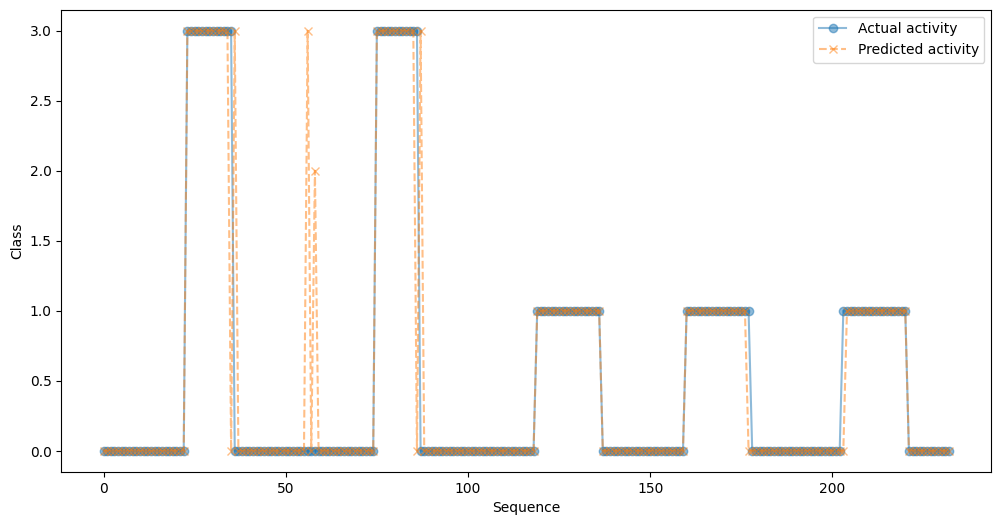

torch.Size([929, 40, 6])


In [13]:
#Visualize
with torch.no_grad():
    logits = model(X_test.to(device))
    predicted = torch.argmax(logits, dim=-1).to('cpu').numpy()

actual = np.argmax(y_test, axis=-1)

plt.figure(figsize=(12, 6))
plt.plot(actual, label='Actual activity', linestyle='-', marker='o', alpha=0.5)
plt.plot(predicted, label='Predicted activity', linestyle='--', marker='x', alpha=0.5)
plt.xlabel('Sequence')
plt.ylabel('Class')
plt.legend()
plt.show()
print(X_train.shape)

In [14]:
actual = np.argmax(y_test, axis=-1)
print(actual)
print(logits)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([[ 8.3656e+00, -4.9955e+00, -7.4780e+00, -3.0261e+00],
        [ 7.3523e+00, -2.9300e+00, -6.9159e+00, -3.7993e+00],
        [ 8.2323e+00, -4.5923e+00, -5.7013e+00, -3.1537e+00],
        [ 7.4837e+00, -4.7388e+00,

In [15]:
!ls drive/MyDrive/watch_activity_model/Recs
save_path = "drive/MyDrive/watch_activity_model/Models/model_tools_real_1.pt"
torch.save(model.state_dict(), save_path)

rec_1	rec_13	rec_17	rec_20	rec_24	rec_28	rec_31	rec_6
rec_10	rec_14	rec_18	rec_21	rec_25	rec_29	rec_32	rec_7
rec_11	rec_15	rec_19	rec_22	rec_26	rec_3	rec_4	rec_8
rec_12	rec_16	rec_2	rec_23	rec_27	rec_30	rec_5	rec_9


In [ ]:
# Save -- #Use the above method to save anad load for python script
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, save_path)


In [16]:
!ls drive/MyDrive/watch_activity_model
load_path = "drive/MyDrive/watch_activity_model/Models/model_tools_real_1.pt"
# Load weights only
checkpoint = torch.load(load_path)
model.load_state_dict(checkpoint)

#Load weights and optimizer state
#model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

Models			  NN_test.ipynb		 Recs	    Untitled0.ipynb
NN_every_timestamp.ipynb  recordings_with_tools  Test_Data  valid_new_whisk


<All keys matched successfully>

In [17]:
longest = 0
for rec in recs:
    watch_acc, watch_acc_ts, watch_gyr, watch_gyr_ts = get_processed_hl_data(rec)
    watch_data = np.hstack((watch_acc, watch_gyr))
    if (len(watch_data) > longest):
      longest = len(watch_data)

big_watch_data = np.zeros((len(recs),longest,6))
count = 0

for rec in recs:
    print(rec)
    watch_acc, watch_acc_ts, watch_gyr, watch_gyr_ts = get_processed_hl_data(rec)
    watch_data = np.hstack((watch_acc, watch_gyr))
    big_watch_data[count,0:len(watch_data),:] = watch_data
    count +=1

print(big_watch_data.shape)
big_watch_data = torch.tensor(big_watch_data).float()


Watch Duration: 25838
Watch Duration: 24150
Watch Duration: 12885
Watch Duration: 25992
Watch Duration: 26950
Watch Duration: 22456
Watch Duration: 131277
Watch Duration: 20464
Watch Duration: 61099
Watch Duration: 25879
Watch Duration: 29776
Watch Duration: 25366
Watch Duration: 16167
Watch Duration: 28608
Watch Duration: 27043
Watch Duration: 24442
Watch Duration: 25498
Watch Duration: 20861
Watch Duration: 25623
drive/MyDrive/watch_activity_model/recordings_with_tools/rec_15
Watch Duration: 25838
drive/MyDrive/watch_activity_model/recordings_with_tools/rec_7
Watch Duration: 24150
drive/MyDrive/watch_activity_model/recordings_with_tools/rec_3
Watch Duration: 12885
drive/MyDrive/watch_activity_model/recordings_with_tools/rec_12
Watch Duration: 25992
drive/MyDrive/watch_activity_model/recordings_with_tools/rec_19
Watch Duration: 26950
drive/MyDrive/watch_activity_model/recordings_with_tools/rec_1
Watch Duration: 22456
drive/MyDrive/watch_activity_model/recordings_with_tools/rec_33
Watc

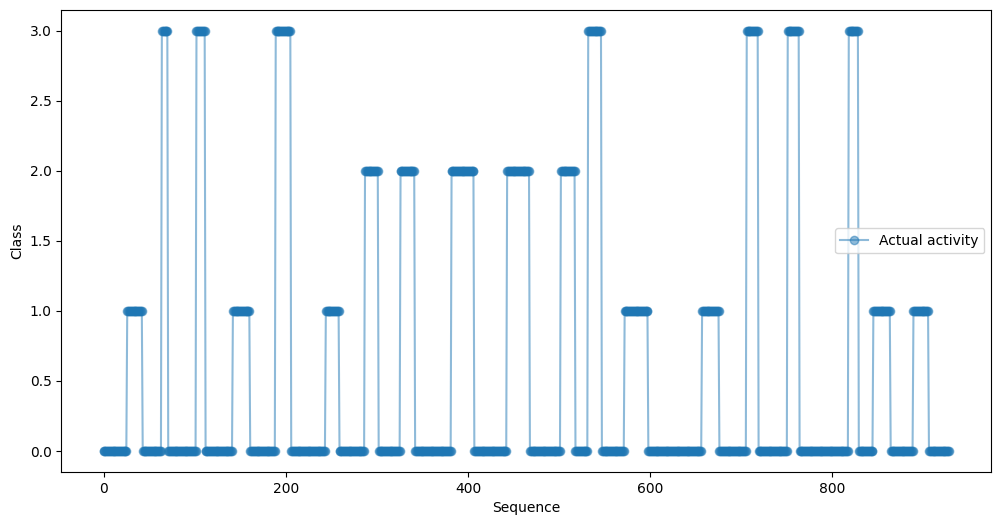

In [18]:
actual = np.argmax(y_train, axis=-1)

plt.figure(figsize=(12, 6))
plt.plot(actual, label='Actual activity', linestyle='-', marker='o', alpha=0.5)
plt.xlabel('Sequence')
plt.ylabel('Class')
plt.legend()
plt.show()

In [19]:
for t in range(10):
  test_input=big_watch_data[:1,t*40:(t+1)*40,:]
  # print(test_input)
  # test_input=X_test[12:13,:,:]
  # print(test_input)
  print(test_input.shape)
  with torch.no_grad():
    out = model(test_input.to(device))
    out = torch.argmax(out, dim=-1).to('cpu').numpy()
  print(out)

torch.Size([1, 40, 6])
[0]
torch.Size([1, 40, 6])
[0]
torch.Size([1, 40, 6])
[0]
torch.Size([1, 40, 6])
[0]
torch.Size([1, 40, 6])
[0]
torch.Size([1, 40, 6])
[0]
torch.Size([1, 40, 6])
[0]
torch.Size([1, 40, 6])
[0]
torch.Size([1, 40, 6])
[0]
torch.Size([1, 40, 6])
[0]


In [20]:
for t in range(60):
  test_input=big_watch_data[:1,t*10:(t+1)*10,:]
  # print(test_input)
  # test_input=X_test[12:13,:,:]
  # print(test_input)
  print(test_input.shape)
  with torch.no_grad():
    out = model(test_input.to(device))
    out = torch.argmax(out, dim=-1).to('cpu').numpy()
  print(out)

torch.Size([1, 10, 6])
[0]
torch.Size([1, 10, 6])
[0]
torch.Size([1, 10, 6])
[0]
torch.Size([1, 10, 6])
[0]
torch.Size([1, 10, 6])
[0]
torch.Size([1, 10, 6])
[0]
torch.Size([1, 10, 6])
[0]
torch.Size([1, 10, 6])
[0]
torch.Size([1, 10, 6])
[0]
torch.Size([1, 10, 6])
[0]
torch.Size([1, 10, 6])
[0]
torch.Size([1, 10, 6])
[0]
torch.Size([1, 10, 6])
[0]
torch.Size([1, 10, 6])
[0]
torch.Size([1, 10, 6])
[0]
torch.Size([1, 10, 6])
[0]
torch.Size([1, 10, 6])
[0]
torch.Size([1, 10, 6])
[0]
torch.Size([1, 10, 6])
[0]
torch.Size([1, 10, 6])
[0]
torch.Size([1, 10, 6])
[0]
torch.Size([1, 10, 6])
[0]
torch.Size([1, 10, 6])
[0]
torch.Size([1, 10, 6])
[0]
torch.Size([1, 10, 6])
[0]
torch.Size([1, 10, 6])
[0]
torch.Size([1, 10, 6])
[0]
torch.Size([1, 10, 6])
[0]
torch.Size([1, 10, 6])
[0]
torch.Size([1, 10, 6])
[0]
torch.Size([1, 10, 6])
[0]
torch.Size([1, 10, 6])
[0]
torch.Size([1, 10, 6])
[0]
torch.Size([1, 10, 6])
[0]
torch.Size([1, 10, 6])
[0]
torch.Size([1, 10, 6])
[0]
torch.Size([1, 10, 6])
[0]
t